In [1]:
import os
import shutil
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import cv2
import torch
import einops
import numpy as np
from PIL import Image
from pytorch_lightning import seed_everything
import torchvision.transforms as transformers

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/yfyuan/anaconda3/envs/semantic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from enum import Enum
from ControlNet.cldm.model import create_model,load_state_dict
from ControlNet.annotator.canny import CannyDetector
from ControlNet.annotator.util import HWC3
from safetensors.torch import load_file

from src.controller import AttentionControl
from src.ddim_v_hacked import DDIMVSampler
from src.img_util import find_flat_region, numpy2tensor

eta = 0.0

In [3]:
model_dict = {
    'Stable Diffusion 1.5': '',
    'revAnimated_v11': 'models/revAnimated_v11.safetensors',
    'realisticVisionV20_v20': 'models/realisticVisionV20_v20.safetensors',
    'DGSpitzer/Cyberpunk-Anime-Diffusion': '~/YYF/all_models/Cyberpunk-Anime-Diffusion.safetensors',
    'wavymulder/Analog-Diffusion': 'analog-diffusion-1.0.safetensors',
    'Fictiverse/Stable_Diffusion_PaperCut_Model': '/home/yfyuan/YYF/all_models/papercut_v1.ckpt',
}
local_model = ['Fictiverse/Stable_Diffusion_PaperCut_Model', 'wavymulder/Analog-Diffusion', 'DGSpitzer/Cyberpunk-Anime-Diffusion']
class ProcessingState(Enum):
    NULL = 0
    FIRST_IMG = 1
    KEY_IMGS = 2
class GlobalState:

    def __init__(self):
        self.sd_model = None
        self.ddim_v_sampler = None
        self.detector_type = None
        self.detector = None
        self.controller = None
        self.processing_state = ProcessingState.NULL

    def update_controller(self, inner_strength, mask_period, cross_period,
                          ada_period, warp_period):
        self.controller = AttentionControl(inner_strength, mask_period,
                                           cross_period, ada_period,
                                           warp_period)

    def update_sd_model(self, sd_model, control_type):
        if sd_model == self.sd_model:
            return
        self.sd_model = sd_model
        model = create_model('./ControlNet/models/cldm_v15.yaml').cpu()
        if control_type == 'HED':
            model.load_state_dict(
                load_state_dict(huggingface_hub.hf_hub_download(
                    'lllyasviel/ControlNet', './models/control_sd15_hed.pth'),
                    location=device))
        elif control_type == 'canny':
            model.load_state_dict(
                load_state_dict('./models/control_sd15_canny.pth',
                                location=device))
        elif control_type == 'depth':
            model.load_state_dict(
                load_state_dict(huggingface_hub.hf_hub_download(
                    'lllyasviel/ControlNet', 'models/control_sd15_depth.pth'),
                    location=device))

        model.to(device)
        sd_model_path = model_dict[sd_model]
        if len(sd_model_path) > 0:
            # check if sd_model is repo_id/name otherwise use global REPO_NAME
            if sd_model.count('/') == 1:
                repo_name = sd_model

            model_ext = os.path.splitext(sd_model_path)[1]
            if model_ext == '.safetensors':
                model.load_state_dict(load_file(sd_model_path), strict=False)
            elif model_ext == '.ckpt' or model_ext == '.pth':
                model.load_state_dict(torch.load(sd_model_path)['state_dict'],
                                      strict=False)

        try:
            model.first_stage_model.load_state_dict(torch.load('./models/vae-ft-mse-840000-ema-pruned.ckpt')['state_dict'],strict=False)
        except Exception:
            print('Warning: We suggest you download the fine-tuned VAE',
                  'otherwise the generation quality will be degraded')

        self.ddim_v_sampler = DDIMVSampler(model)

    def clear_sd_model(self):
        self.sd_model = None
        self.ddim_v_sampler = None
        if device == 'cuda':
            torch.cuda.empty_cache()

    def update_detector(self, control_type, canny_low=100, canny_high=200):
        if self.detector_type == control_type:
            return
        if control_type == 'HED':
            self.detector = HEDdetector()
        elif control_type == 'canny':
            canny_detector = CannyDetector()
            low_threshold = canny_low
            high_threshold = canny_high

            def apply_canny(x):
                return canny_detector(x, low_threshold, high_threshold)

            self.detector = apply_canny

        elif control_type == 'depth':
            midas = MidasDetector()

            def apply_midas(x):
                detected_map, _ = midas(x)
                return detected_map

            self.detector = apply_midas

In [4]:
global_state = GlobalState()

# sd_model = 'revAnimated_v11'
sd_model = 'realisticVisionV20_v20' #真实风格
# sd_model = 'DGSpitzer/Cyberpunk-Anime-Diffusion' #赛博朋克风格
# sd_model = 'wavymulder/Analog-Diffusion' # 人物传记风格
# sd_model = 'Fictiverse/Stable_Diffusion_PaperCut_Model' # 剪纸风格
control_type = 'canny'
low_threshold = 50
high_threshold = 100

In [5]:
global_state.update_sd_model(sd_model, control_type)
global_state.update_controller(0,0,0,0,0)
# global_state.update_controller(0,0,0,0,0)
global_state.update_detector(control_type, low_threshold, high_threshold)

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla-xformers' with 512 in_channels
building MemoryEfficientAttnBlock with 512 in_channels...


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.11.self_attn.v_proj.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.15.self_attn.v_proj.weight', 'vision_model.encoder.layers.18.mlp.fc2.bias', 'vision_model.encoder.layers.10.self_attn.k_proj.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.weight', 'vision_model.encoder.layers.5.mlp.fc1.weight', 'vision_model.encoder.layers.9.self_attn.q_proj.bias', 'vision_model.encoder.layers.7.mlp.fc2.bias', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.12.mlp.fc2.bias', 'vision_model.encoder.layers.19.mlp.fc1.bias', 'vision_model.encoder.layers.20.mlp.fc2.bias', 'vision_model.encoder.layers.3.self_attn.v_proj.bias', 'vision_model.encoder.layers.3.mlp.fc2.weight', 'vision_model.encoder.layers.2.mlp.fc2.weight', 'vi

Loaded model config from [./ControlNet/models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_canny.pth]


In [205]:
def save_feature_maps(blocks, i, feature_type="input_block"):
    if (i not in [1,2,5,19]):
        return
    block_idx = 0
    for block in blocks:
#         if feature_type == "input_block":
#             if "Downsample" in str(type(block[0])):
#                 save_feature_map(block[0].down_input_feature,
#                                  f"{feature_type}_{block_idx}_downsample_input_time_{i}")
#                 save_feature_map(block[0].down_output_feature,
#                                  f"{feature_type}_{block_idx}_downsample_output_time_{i}")

#             if "ResBlock" in str(type(block[0])):
#                 save_feature_map(block[0].in_layers_features,
#                                  f"{feature_type}_{block_idx}_in_layers_features_time_{i}")
#                 save_feature_map(block[0].out_layers_features,
#                                  f"{feature_type}_{block_idx}_out_layers_features_time_{i}")
#                 save_feature_map(block[0].out_layers_features,
#                                  f"{feature_type}_{block_idx}_emb_layers_features_time_{i}")

#             if len(block) > 1 and "SpatialTransformer" in str(type(block[1])):
#                 save_feature_map(block[1].attention_output, 
#                                 f"{feature_type}_{block_idx}_out_trans_time_{i}")

        if feature_type == "output_block":
            # if "ResBlock" in str(type(block[0])):
            #     save_feature_map(block[0].res_all_in,
            #                      f"{feature_type}_{block_idx}_all_in_layers_features_time_{i}")
            #     save_feature_map(block[0].res_all_out,
            #                      f"{feature_type}_{block_idx}_all_out_layers_features_time_{i}")
            #     save_feature_map(block[0].emb,
            #                      f"{feature_type}_{block_idx}_emb_layers_features_time_{i}")

            if len(block) > 1 and "SpatialTransformer" in str(type(block[1])):
                # save_feature_map(block[1].transformer_blocks[0].attn1.attn_in,
                                 # f"{feature_type}_{block_idx}_in_self_attn_time_{i}")
                if block_idx == 8:
                    save_feature_map(block[1].transformer_blocks[0].attn1.tmp_sim,
                                     f"{feature_type}_{block_idx}_out_self_attn_time_{i}")
                # save_feature_map(block[1].transformer_blocks[0].attn2.attn_in,
                #                  f"{feature_type}_{block_idx}_in_cross_attn_time_{i}")
                # save_feature_map(block[1].transformer_blocks[0].attn2.attn_out,
                #                  f"{feature_type}_{block_idx}_out_cross_attn_time_{i}")
                # save_feature_map(block[1].transformer_blocks[0].trans_in,
                #                  f"{feature_type}_{block_idx}_in_trans_time_{i}")
                # save_feature_map(block[1].transformer_blocks[0].trans_out,
                #                  f"{feature_type}_{block_idx}_out_trans_time_{i}")
                    save_feature_map(block[1].attention_output, 
                                    f"{feature_type}_{block_idx}_out_trans_time_{i}")



        # if len(block) > 1 and "SpatialTransformer" in str(type(block[1])): # block:[resblock, spatial]
        #     save_feature_map(block[1].transformer_blocks[0].attn1.sa_in, f"{feature_type}_{block_idx}_self_attn_in_time_{i}")
        #     save_feature_map(block[1].transformer_blocks[0].attn1.sa_out, f"{feature_type}_{block_idx}_self_attn_out_time_{i}")
        #     if len(block) > 1 and "SpatialTransformer" in str(type(block[1])) and block_idx in [3,4,5]: # block:[resblock, spatial]
        #         save_feature_map(block[1].transformer_blocks[0].attn1.tmp_sim, f"{feature_type}_{block_idx}_self_attn_time_{i}")
        block_idx += 1

def save_feature_maps_callback(i, unet_model):
    save_feature_maps(unet_model.input_blocks, i, "input_block")
    save_feature_maps(unet_model.output_blocks, i, "output_block")


def save_feature_map(feature_map, filename):
    os.makedirs(feature_maps_path, exist_ok=True)
    save_path = os.path.join(feature_maps_path, f"{filename}.pt")
    print(f"saving feature map in {save_path}")
    torch.save(feature_map, save_path)

In [206]:
@torch.no_grad()
def single_inversion(x0, ddim_v_sampler, img_callback=None):
    # controller.cls = "attn"
    model = ddim_v_sampler.model

    prompt = f""
    cond = {
        'c_concat': None,
        'c_crossattn': [
            model.get_learned_conditioning(
                [prompt]
            )
        ]
    }
    un_cond = {
        'c_concat': None,
        'c_crossattn': [
            model.get_learned_conditioning(
                ['']
            )
        ]
    }
    ddim_v_sampler.encode_ddim(x0, 1000, cond, un_cond, controller=None, img_callback=img_callback)

In [202]:
%%capture
ddim_v_sampler = global_state.ddim_v_sampler
model = ddim_v_sampler.model
detector = global_state.detector
controller = global_state.controller
controller.set_task('')
model.control_scales = [0.9] * 13
model.to(device)

In [279]:
######### 批量出图  ##########
first_strength = 1 - 0.99

# processed = [dir_name[:-len("realisticVisionV20_v20_20")-1] for dir_name in os.listdir("/home/yfyuan/YYF/Rerender/exp/ImageNet/results")]

prompt = f"realistic photo"
# prompt = f"in cartoon style"
a_prompt = "RAW photo, subject, (high detailed skin:1.2), 8k uhd, dslr, high quality, film grain"
n_prompt = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime, mutated hands and fingers:1.4), (deformed, distorted, disfigured:1.3), poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, amputation"

# prompt = "((Papercut)), shapes, delicate patterns, silhouette, kirigami, sharp outline, Spread the picture"
# a_prompt = "(masterpiece, top quality, best quality)"
# n_prompt = "frame,decorations"

# prompt = "Cyberpunk style"
# a_prompt = "(masterpiece, best quality:1.2), ultra-high resolution, intricately detailed, futuristic cyberpunk car, dynamic lighting, sleek design, ((visually captivating)), lora:CyberPunkAI:.8 CyberPunkAI car on a neon-lit city street, (((cyberpunk atmosphere))) or speeding through a rain-soaked metropolis, (((cyberpunk aesthetics))), amidst a dense cybernetic cityscape, (((cyberpunk allure)))"
# n_prompt = "UnwantedElements, rough-hands-5, (grainy:1.4), (worst quality, low quality:1.4), blurry, unrealistic physique, inappropriate themes, badv4"

In [350]:
seed_everything(0)
# 0 5 8 9
from tqdm.notebook import tqdm
num_samples = 1
steps = 1
unet_model = model.model.diffusion_model
dir_ = "ice_cream"
img_name = "misc_10.jpg"
img_dir = f"/home/yfyuan/YYF/Rerender/exp/ImageNet/imagenet-r/{dir_}"

feature_maps_path = "/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn"
feature_maps_path_denoising = os.path.join(feature_maps_path, f"{dir_}")
feature_maps_path_inv = os.path.join(feature_maps_path, f"{dir_}_inv")
unet_model.batch_frame_attn_feature_path = feature_maps_path_inv
controller.set_task('')
img_path = os.path.join(img_dir, img_name)
img_path = "/home/yfyuan/YYF/tmp/misc_10_sd.jpg"
with torch.no_grad():
    def ddim_sampler_callback(i):
        save_feature_maps_callback(i, unet_model)
    def generate_first_img(x0, img, strength):
        samples, _ = ddim_v_sampler.sample(
            steps,
            num_samples,
            shape,
            cond,
            verbose=False,
            eta=eta,
            unconditional_guidance_scale=7.5,
            unconditional_conditioning=un_cond,
            controller=controller,
            x0=x0,
            strength=strength,
            img_callback=ddim_sampler_callback)
        x_samples = model.decode_first_stage(samples)
        x_samples_np = (
                einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 +
                127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
        return x_samples, x_samples_np

    frame = cv2.imread(img_path)
    shape = frame.shape
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = np.array(transformers.CenterCrop((frame.shape[0] // 64 * 64, frame.shape[1] // 64 * 64))(Image.fromarray(frame)))
    
    img = HWC3(frame)
    H, W, C = img.shape
    shape = (4, H // 8, W // 8)
    img_ = numpy2tensor(img)
    
    encoder_posterior = model.encode_first_stage(img_.to(device))
    x0 = model.get_first_stage_encoding(encoder_posterior).detach()

    feature_maps_path = feature_maps_path_inv
    # single_inversion(x0, ddim_v_sampler, ddim_sampler_callback)
    
    feature_maps_path = feature_maps_path_denoising

    detected_map = detector(img)
    detected_map = HWC3(detected_map)
    control = torch.from_numpy(detected_map.copy()).float().to(device) / 255.0
    control = torch.stack([control for _ in range(num_samples)], dim=0)
    control = einops.rearrange(control, 'b h w c -> b c h w').clone()
    cond = {
        'c_concat': [control],
        'c_crossattn': [
            model.get_learned_conditioning(
                [prompt + ', ' + a_prompt] * num_samples)
        ]
    }
    un_cond = {
        'c_concat': [control],
        'c_crossattn':
            [model.get_learned_conditioning([n_prompt] * num_samples)]
    }

    unet_model.unet_type = "denoising"
    controller.set_task('')
    # unet_model.unet_type = "spatial"
    unet_model.batch_frame_attn_feature = feature_maps_path

    # x_samples, x_samples_np = generate_first_img(x0, img, 1.95)
    x_samples, x_samples_np = generate_first_img(x0, img, first_strength)

Global seed set to 0


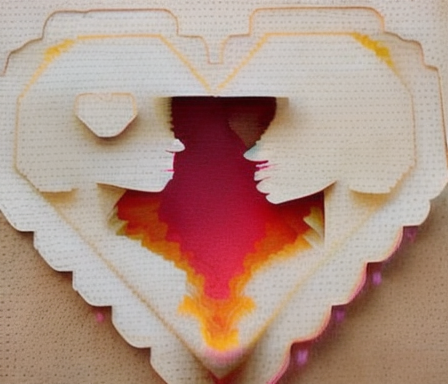

In [351]:
# Image.open(img_path)
display(Image.fromarray(x_samples_np[0]))
# unet_model.batch_frame_attn_feature

In [349]:
Image.fromarray(x_samples_np[0]).save(f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/exp_attn_vis/{dir_}.png")
# Image.fromarray(x_samples_np[0]).save(f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/exp_attn_vis/{dir_}_no.png")
# Image.fromarray(frame).save("/home/yfyuan/YYF/panda.png")
# Image.open("/home/yfyuan/YYF/starfish.png")

In [267]:
model.model.diffusion_model.output_blocks[8][0].emb.shape

torch.Size([1, 1280])

In [297]:
from sklearn.decomposition import PCA
from einops import rearrange
from torchvision import transforms as T
from einops import rearrange

In [329]:
pca = PCA(n_components=3)

In [339]:
# attn_map_path = feature_maps_path_inv
# attn_map_path = feature_maps_path_denoising
attn_map_path = f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/{dir_}"
# attn_map_path = f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/{dir_}"
block_idx = 8
# block_idx = 5
t = 8
feature_type = "output_block"
attn_map_path = os.path.join(attn_map_path,f"{feature_type}_{block_idx}_out_self_attn_time_{19}.pt")
print(attn_map_path)
attn_map = torch.load(attn_map_path)
print(attn_map.shape)

/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/ice_cream/output_block_8_out_self_attn_time_19.pt
torch.Size([8, 672, 672])


In [340]:
self_attn_map = rearrange(attn_map, 'h n m -> n (h m)')
self_attn_map = self_attn_map.cpu().numpy()

In [341]:
print(self_attn_map.shape)

(672, 5376)


In [342]:
%%capture
pca.fit(self_attn_map)

In [343]:
self_attn_map = pca.transform(self_attn_map)
print(self_attn_map.shape)
self_attn_map = self_attn_map.reshape(1,-1,3)
b,n,f = self_attn_map.shape
print(b,n,f)

(672, 3)
1 672 3


In [344]:
pca_img = self_attn_map.reshape(24, 28, 3)
# pca_img = self_attn_map.reshape(24 // 1,28 // 1,3)
pca_img_min = pca_img.min(axis=(0, 1))
pca_img_max = pca_img.max(axis=(0, 1))
pca_img = (pca_img - pca_img_min) / (pca_img_max - pca_img_min)
pca_img = Image.fromarray((pca_img * 255).astype(np.uint8))
pca_img = T.Resize(512, interpolation=T.InterpolationMode.NEAREST)(pca_img)

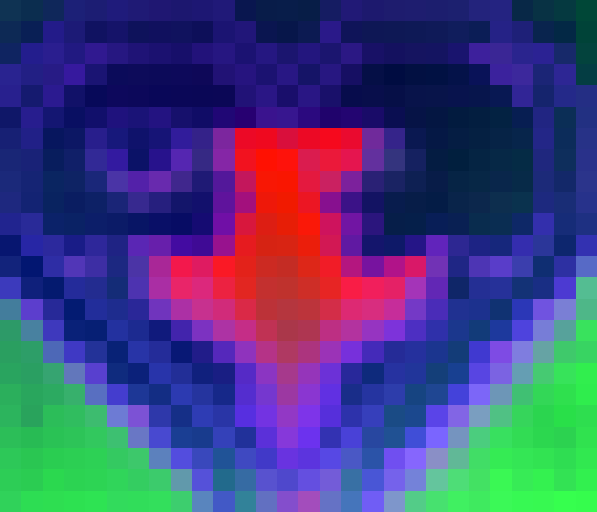

In [325]:
display(pca_img)

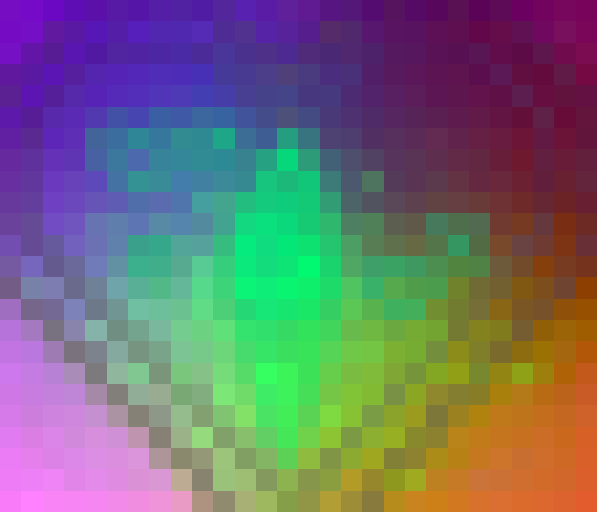

In [345]:
display(pca_img)

In [346]:
print(f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/exp_attn_vis/{dir_}_block_{block_idx}_no.png")
pca_img.save(f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/exp_attn_vis/{dir_}_block_{block_idx}_no.png")
# pca_img.save(f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/exp_attn_vis/{dir_}_block_{block_idx}_t_{t}_denoising.png")

/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/exp_attn_vis/ice_cream_block_8_no.png


In [306]:
pca_img.save(f"/home/yfyuan/YYF/Rerender/exp/attn_map/exp_attn/exp_attn_vis/{dir_}_block_{block_idx}.png")

In [14]:
import torch
a = torch.tensor([800,])

In [15]:
if(a > 500):
    print(1)

1


In [16]:
a

tensor([800])

In [20]:
a = [1,2,3,4]

In [21]:
a.pop()

4

In [22]:
a

[1, 2, 3]